# Create Map for the City of New Orleans

New Orleans maps are created by this notebook

In [1]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import cartopy
from datetime import datetime
import os
import pyproj

In [2]:
outPath = f"output{os.sep}"
dataPath = f"datasets{os.sep}"
wgs84 = pyproj.CRS.from_string('WGS84')

In [3]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-03-28 18:23:21.612798] Starting...


In [4]:
lp(f"outPath:  {outPath}")
lp(f"dataPath:  {dataPath}")

[2025-03-28 18:23:21.617112] outPath:  output/
[2025-03-28 18:23:21.617379] dataPath:  datasets/


In [6]:
lp("Loading 100m lidar data")
data100m = gpd.read_parquet(f"{outPath}AggregateLidarData_100m.parquet")
bounds100m = data100m.total_bounds

lp("Loading 10m lidar data")
data10m = gpd.read_parquet(f"{outPath}AggregateLidarData_SomeHoods_10m.parquet")

[2025-03-28 18:23:40.323409] Loading 100m lidar data
[2025-03-28 18:23:40.392168] Loading 10m lidar data


In [7]:
crs = data100m.crs
lp(f"CRS:  {crs.name}")

[2025-03-28 18:23:40.942317] CRS:  NAD83(2011) / UTM zone 15N + NAVD88 height - Geoid18 (metres)


In [8]:
lp("Creating CRS transformers")
crsToWgs84 = pyproj.Transformer.from_crs(crs_from=crs, crs_to=wgs84)
lp(crsToWgs84)

[2025-03-28 18:23:41.397809] Creating CRS transformers
[2025-03-28 18:23:41.412315] proj=pipeline step inv proj=utm zone=15 ellps=GRS80 step proj=unitconvert xy_in=rad xy_out=deg step proj=axisswap order=2,1


In [21]:
lp("Loading neighborhoos data")
neighborhoodsDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").set_index('gnocdc_lab').to_crs(crs)
neighborhoodsDf.head(2)

[2025-03-28 18:25:33.097584] Loading neighborhoos data


,neigh_id,objectid,lup_lab,shape_stlength,shape_starea,geometry
gnocdc_lab,,,,,,
B. W. COOPER,12D,6,B. W. COOPER HOUSING DEV,12118.012710324232,8808477.0902902912,"MULTIPOLYGON (((781325.808 3316870.195, 781298..."
HOLY CROSS,15C,32,HOLY CROSS,21187.180302661334,26999609.302162763,"MULTIPOLYGON (((788931.478 3317916.911, 788404..."


In [10]:
lp("Loading water")
waterDf = gpd.read_file(f"{dataPath}WATER2.SHP").set_crs(wgs84).to_crs(crs)

[2025-03-28 18:23:42.014665] Loading water


/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 3 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(
/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 4 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(
/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geom

In [32]:
def processLidar(df):
    df['AltitudeMeters'] = (df['AltitudeTotal'] / df['Total']) / 1000.0
    df['Altitude'] = df['AltitudeMeters'] / 3.28084
    df['WaterPerc'] = df['WaterTotal'] / df['Total'] * 100.0
    df['IsWater'] = df['WaterPerc'] > 50.0

    return df

lp("Processing 100m lidar")
data100m = processLidar(data100m)
data10m = processLidar(data10m)

[2025-03-28 18:28:32.708359] Processing 100m lidar


In [33]:
def tickPtFormater(pt):

    deg = int(pt)
    mins = round((pt - deg) * 60)
    
    return f"{deg}\u00B0 {mins}'"

def tickFormater(x,y):
    wgsPTS = crsToWgs84.transform(x,y)

    formated = tuple(map(tickPtFormater, wgsPTS))

    return formated

In [34]:
data100m.head(1)

,geometry,AltitudeTotal,WaterTotal,Total,RunTime,AltitudeMeters,Altitude,WaterPerc,IsWater
76,"POLYGON ((776139 3315488, 776139 3315588, 7760...",0.0,0.0,0.0,0 days 00:00:07.441123,NaN,NaN,NaN,False


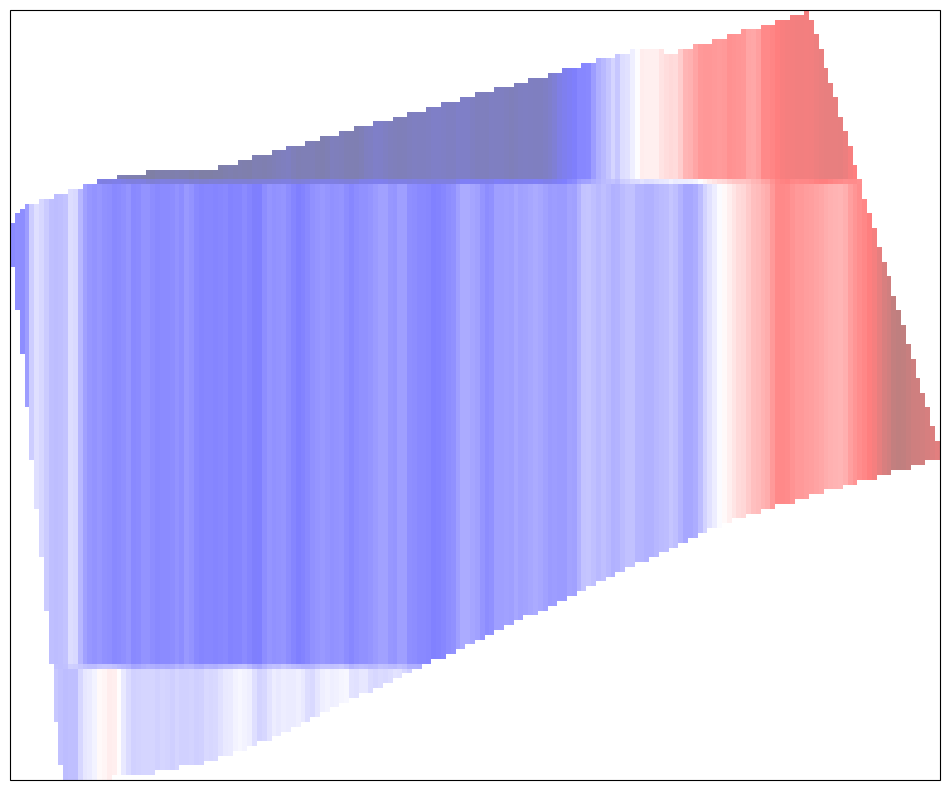

In [54]:
cartopyCRS = cartopy.crs.UTM(15)
def createMap(df,column,bounds,vmin,vmax,cmap='seismic', alpha=0.5):

    normalizer = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    cmapTrans = matplotlib.colormaps.get_cmap(cmap)
    xMidpoint = bounds[2] - bounds[0]
    yMidpoint = bounds[3] - bounds[1]
    
    fig, ax = plt.subplots(figsize=(15,10), subplot_kw={ 'projection':cartopyCRS})
    
    #data100m.plot(ax=ax,column='Altitude', legend=True)
    colors = cmapTrans( normalizer( df[column] ) )
    colors[:,3] = alpha
    ax.add_geometries(df['geometry'], crs=cartopyCRS, color=colors, edgecolor=None)
    
    waterDf.plot(ax=ax, color='lightblue', label='water')
    
    ax.set_xlim((bounds[0], bounds[2]))
    ax.set_ylim((bounds[1], bounds[3]))

    ax.xaxis.set_major_formatter(lambda x, pos: tickFormater(x,yMidpoint)[1])
    ax.yaxis.set_major_formatter(lambda y, pos: tickFormater(xMidpoint,y)[0])
    ax.tick_params(which='both')
    
    plt.plot()
    
    return

gentillyDf = data10m[data10m.intersects(neighborhoodsDf.loc['GENTILLY WOODS','geometry'])]
createMap(gentillyDf, 'Altitude', gentillyDf.total_bounds , vmin=gentillyDf['Altitude'].min(), vmax=gentillyDf['Altitude'].max())


In [48]:
colors

array([[0.09803922, 0.09803922, 1.        , 0.5       ],
       [0.09803922, 0.09803922, 1.        , 0.5       ],
       [0.09803922, 0.09803922, 1.        , 0.5       ],
       ...,
       [0.7745098 , 0.        , 0.        , 0.5       ],
       [0.7745098 , 0.        , 0.        , 0.5       ],
       [0.7745098 , 0.        , 0.        , 0.5       ]], shape=(19545, 4))

np.int64(1)

In [ ]:
normalizer = matplotlib.colors.Normalize(vmin=-5, vmax=5, clip=True)
matplotlib.colormaps.get_cmap('magma')(normalizer(data100m['Altitude']))

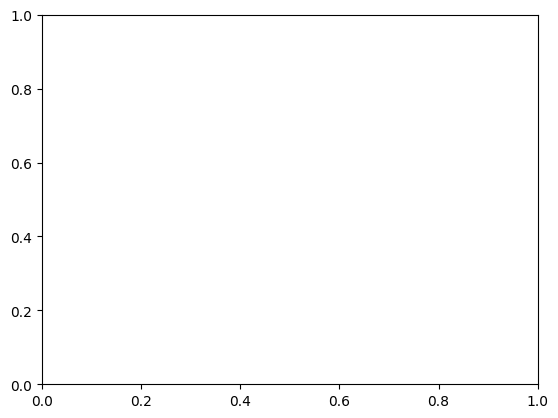

In [53]:
fig, ax = plt.subplots()

In [ ]:
ax.tick_params